In [68]:
import numpy as np
import pandas as pd
import torch as torch
import matplotlib.pyplot as plt
import os
import datetime as dt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [69]:
dir_path = r'C:\Users\Aakash Ashok\new_data'

In [70]:
def get_files(dir_path, filename):
    return pd.read_csv(os.path.join(dir_path, filename), sep='\t', header=None)

In [71]:
# importing all pressure sensor data
pressureFile1 = get_files(dir_path=dir_path, filename='PS1.txt')
pressureFile2 = get_files(dir_path=dir_path, filename='PS2.txt')
pressureFile3 = get_files(dir_path=dir_path, filename='PS3.txt')
pressureFile4 = get_files(dir_path=dir_path, filename='PS4.txt')
pressureFile5 = get_files(dir_path=dir_path, filename='PS5.txt')
pressureFile6 = get_files(dir_path=dir_path, filename='PS6.txt')

In [72]:
# importing all temperature data
temperature1 = get_files(dir_path=dir_path, filename='TS1.txt')
temperature2 = get_files(dir_path=dir_path, filename='TS2.txt')
temperature3 = get_files(dir_path=dir_path, filename='TS3.txt')
temperature4 = get_files(dir_path=dir_path, filename='TS4.txt')

In [73]:
# importing all volume flow data
volumeFlow1 = get_files(dir_path=dir_path, filename='FS1.txt')
volumeFlow2 = get_files(dir_path=dir_path, filename='FS2.txt')

In [74]:
pump1 = get_files(dir_path=dir_path, filename='EPS1.txt')
vibration1 = get_files(dir_path=dir_path, filename='VS1.txt')
coolingE1 = get_files(dir_path=dir_path, filename='CE.txt')
coolingP1 = get_files(dir_path=dir_path, filename='CP.txt')
effFactor1 = get_files(dir_path=dir_path, filename='SE.txt')

In [75]:
# Importing the data where the target condition values are cycle-wise annotated  ( label data)
profile = get_files(dir_path=dir_path, filename='profile.txt')

In [76]:
# assigning different variables to the targets
target_list = ['y_coolerCondition','y_valveCondition','y_pumpLeak ','y_hydraulicAcc','y_stableFlag']
y_coolerCondition = pd.DataFrame(profile.iloc[:, 0])
y_valveCondition = pd.DataFrame(profile.iloc[:, 1])
y_pumpLeak = pd.DataFrame(profile.iloc[:, 2])
y_hydraulicAcc = pd.DataFrame(profile.iloc[:, 3])
y_stableFlag = pd.DataFrame(profile.iloc[:, 4])

target_data = pd.concat([y_coolerCondition,y_valveCondition,y_pumpLeak ,y_hydraulicAcc,y_stableFlag], axis=1, sort=False)
target_data.head

<bound method NDFrame.head of         0    1  2    3  4
0       3  100  0  130  1
1       3  100  0  130  1
2       3  100  0  130  1
3       3  100  0  130  1
4       3  100  0  130  1
5       3  100  0  130  1
6       3  100  0  130  1
7       3  100  0  130  1
8       3  100  0  130  1
9       3  100  0  130  1
10      3  100  0  130  1
11      3  100  0  130  1
12      3  100  0  130  1
13      3  100  0  130  1
14      3  100  0  130  1
15      3  100  0  130  1
16      3  100  0  130  1
17      3  100  0  130  1
18      3  100  0  130  1
19      3  100  0  130  1
20      3  100  0  130  1
21      3  100  0  130  1
22      3  100  0  130  1
23      3  100  0  130  1
24      3  100  0  130  1
25      3  100  0  130  1
26      3  100  0  130  1
27      3  100  0  130  1
28      3  100  0  130  1
29      3  100  0  130  1
...   ...  ... ..  ... ..
2175  100   80  0   90  0
2176  100   90  0   90  0
2177  100   90  0   90  0
2178  100   90  0   90  0
2179  100   90  0   90  0
2180  10

In [77]:
target_data.describe()

,0,1,2,3,4
count,2205.000000,2205.000000,2205.000000,2205.000000,2205.000000
mean,41.240816,90.693878,0.669388,107.199546,0.342857
std,42.383143,10.681802,0.817233,16.435848,0.474772
min,3.000000,73.000000,0.000000,90.000000,0.000000
25%,3.000000,80.000000,0.000000,90.000000,0.000000
50%,20.000000,100.000000,0.000000,100.000000,0.000000
75%,100.000000,100.000000,1.000000,130.000000,1.000000
max,100.000000,100.000000,2.000000,130.000000,1.000000


In [38]:
# Load in the target variables as a Pandas DataFrame

filename = 'profile.txt'
condition = pd.read_csv(os.path.join(dir_path, filename), sep='\t', header=None, names = target_list)

# Preview the first few lines
condition.head()

,y_coolerCondition,y_valveCondition,y_pumpLeak,y_hydraulicAcc,y_stableFlag
0,3,100,0,130,1
1,3,100,0,130,1
2,3,100,0,130,1
3,3,100,0,130,1
4,3,100,0,130,1


In [52]:
# checking target values
for i in enumerate(list(target_list)):
    print(pd.unique(condition[i[1]]))

[  3  20 100]
[100  73  80  90]
[0 2 1]
[130 115 100  90]
[1 0]


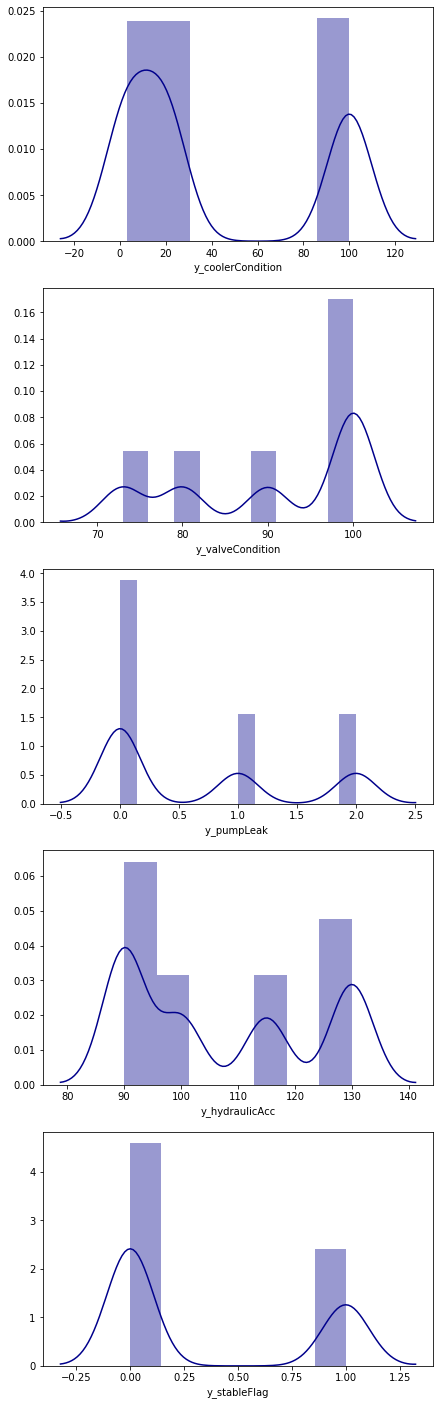

In [55]:
#Visulalization of target variables
# Constructing 5 subplots for the 5 target variables 
figure,(ax1, ax2,ax3,ax4,ax5) = plt.subplots(figsize=(7, 25 ), 
                       nrows=condition.shape[1], ncols=1,sharex = False)

sns.distplot(condition[target_list[0]], hist=True, color = 'darkblue',ax=ax1)
sns.distplot(condition[target_list[1]], hist=True,color = 'darkblue',ax=ax2)
sns.distplot(condition[target_list[2]], hist=True, color = 'darkblue',ax=ax3)
sns.distplot(condition[target_list[3]], hist=True,color = 'darkblue',ax=ax4)
sns.distplot(condition[target_list[4]], hist=True, color = 'darkblue',ax=ax5)

In [56]:
"""
1 :Cooler condition / %:
	3: close to total failure
	20: reduced effifiency
	100: full efficiency

2: Valve condition / %:
	100: optimal switching behavior
	90: small lag
	80: severe lag
	73: close to total failure

3: Internal pump leakage:
	0: no leakage
	1: weak leakage
	2: severe leakage

4: Hydraulic accumulator / bar:
	130: optimal pressure
	115: slightly reduced pressure
	100: severely reduced pressure
	90: close to total failure

5: stable flag:
	0: conditions were stable
	1: static conditions might not have been reached yet
"""

'\n1 :Cooler condition / %:\n\t3: close to total failure\n\t20: reduced effifiency\n\t100: full efficiency\n\n2: Valve condition / %:\n\t100: optimal switching behavior\n\t90: small lag\n\t80: severe lag\n\t73: close to total failure\n\n3: Internal pump leakage:\n\t0: no leakage\n\t1: weak leakage\n\t2: severe leakage\n\n4: Hydraulic accumulator / bar:\n\t130: optimal pressure\n\t115: slightly reduced pressure\n\t100: severely reduced pressure\n\t90: close to total failure\n\n5: stable flag:\n\t0: conditions were stable\n\t1: static conditions might not have been reached yet\n'

In [57]:
# Taking mean
def get_mean(df):
    df1 = pd.DataFrame()
    df1 = df.mean(axis = 1)
    return df1

In [58]:
PS1 = pd.DataFrame(get_mean(pressureFile1))
PS1.columns = ['PS1']

PS2 = pd.DataFrame(get_mean(pressureFile2))
PS2.columns = ['PS2']

PS3 = pd.DataFrame(get_mean(pressureFile3))
PS3.columns = ['PS3']

PS4 = pd.DataFrame(get_mean(pressureFile4))
PS4.columns = ['PS4']

PS5 = pd.DataFrame(get_mean(pressureFile5))
PS5.columns = ['PS5']

PS6 = pd.DataFrame(get_mean(pressureFile6))
PS6.columns = ['PS6']

FS1 = pd.DataFrame(get_mean(volumeFlow1))
FS1.columns = ['FS1']

FS2 = pd.DataFrame(get_mean(volumeFlow2))
FS2.columns = ['FS2']

TS1 = pd.DataFrame(get_mean(temperature1))
TS1.columns = ['TS1']

TS2 = pd.DataFrame(get_mean(temperature2))
TS2.columns = ['TS2']

TS3 = pd.DataFrame(get_mean(temperature3))
TS3.columns = ['TS3']

TS4 = pd.DataFrame(get_mean(temperature4))
TS4.columns = ['TS4']

P1 = pd.DataFrame(get_mean(pump1))
P1.columns = ['P1']

VS1 = pd.DataFrame(get_mean(vibration1))
VS1.columns = ['VS1']

CE1 = pd.DataFrame(get_mean(coolingE1))
CE1.columns = ['CE1']

CP1 = pd.DataFrame(get_mean(coolingP1))
CP1.columns = ['CP1']

SE1 = pd.DataFrame(get_mean(effFactor1))
SE1.columns = ['SE1']

In [59]:
X = pd.concat([PS1, PS2, PS3, PS4, PS5, PS6, FS1, FS2, TS1, TS2, TS3, TS4, P1, VS1, CE1, CP1, SE1], axis=1)

In [60]:
X.info

<bound method DataFrame.info of              PS1         PS2       PS3           PS4       PS5       PS6  \
0     160.673492  109.466914  1.991475  0.000000e+00  9.842170  9.728097   
1     160.603320  109.354890  1.976234  0.000000e+00  9.635142  9.529488   
2     160.347720  109.158845  1.972224  0.000000e+00  9.530548  9.427949   
3     160.188088  109.064807  1.946575  0.000000e+00  9.438827  9.337430   
4     160.000472  108.931434  1.922707  0.000000e+00  9.358762  9.260636   
5     159.920210  108.887682  1.913284  0.000000e+00  9.301160  9.206877   
6     159.672675  108.676466  1.888100  0.000000e+00  9.233942  9.143320   
7     159.614452  108.651745  1.874894  0.000000e+00  9.194159  9.105058   
8     159.475745  108.529738  1.858120  0.000000e+00  9.144616  9.057067   
9     159.437997  108.510885  1.841063  0.000000e+00  9.104831  9.019265   
10    159.321757  108.437852  1.832484  0.000000e+00  9.068217  8.983758   
11    159.235113  108.316782  1.825662  0.000000e+00  9.

In [61]:
X.head

<bound method NDFrame.head of              PS1         PS2       PS3           PS4       PS5       PS6  \
0     160.673492  109.466914  1.991475  0.000000e+00  9.842170  9.728097   
1     160.603320  109.354890  1.976234  0.000000e+00  9.635142  9.529488   
2     160.347720  109.158845  1.972224  0.000000e+00  9.530548  9.427949   
3     160.188088  109.064807  1.946575  0.000000e+00  9.438827  9.337430   
4     160.000472  108.931434  1.922707  0.000000e+00  9.358762  9.260636   
5     159.920210  108.887682  1.913284  0.000000e+00  9.301160  9.206877   
6     159.672675  108.676466  1.888100  0.000000e+00  9.233942  9.143320   
7     159.614452  108.651745  1.874894  0.000000e+00  9.194159  9.105058   
8     159.475745  108.529738  1.858120  0.000000e+00  9.144616  9.057067   
9     159.437997  108.510885  1.841063  0.000000e+00  9.104831  9.019265   
10    159.321757  108.437852  1.832484  0.000000e+00  9.068217  8.983758   
11    159.235113  108.316782  1.825662  0.000000e+00  9.02

In [62]:
#Saving these two dataframes into a pickle object for further procedure
#So that only loading of these dataframes is required
X.to_pickle("X.pkl")
target_data.to_pickle("Y.pkl")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000205B080CF98>,
      dtype=object)

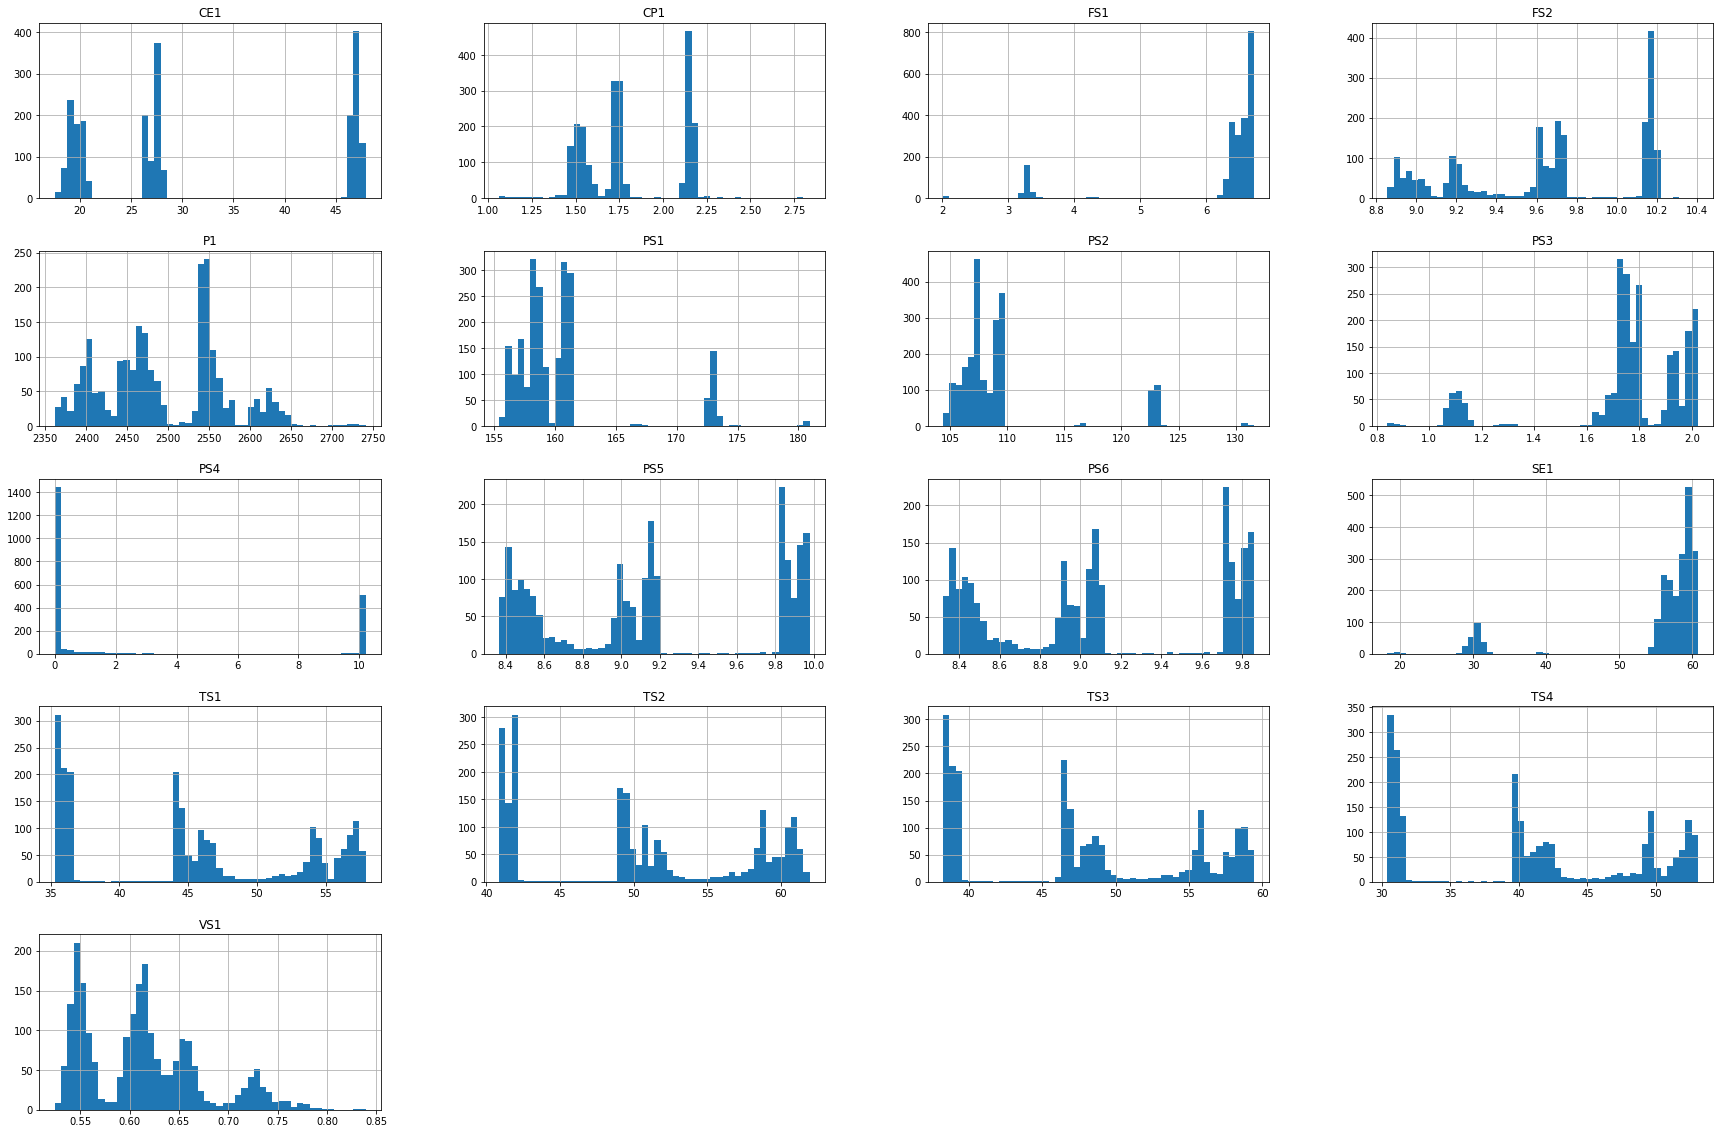

In [63]:
X.hist(bins=50, figsize=(30, 20))

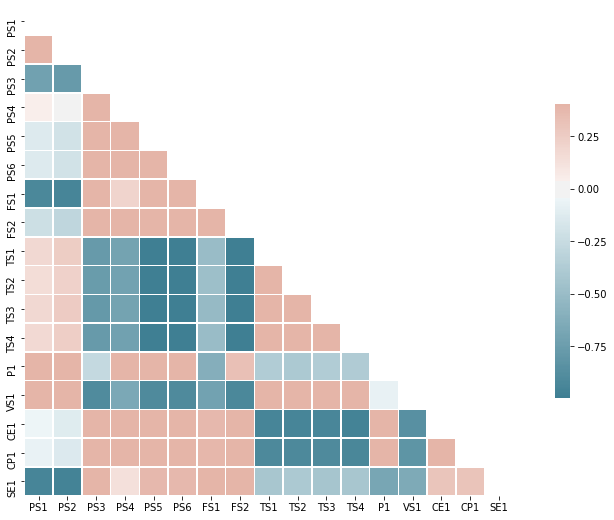

In [64]:
corr_matrix = X.corr()
mask = np.zeros_like(corr_matrix, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(15, 9))
cmap = sns.diverging_palette(220, 20, as_cmap=True)
sns.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.4, center=0,
            square=True, cbar_kws={"shrink": .6}, linewidths=.6)

Text(0.5, 1.0, 'PCA explained variance vs. n componets')

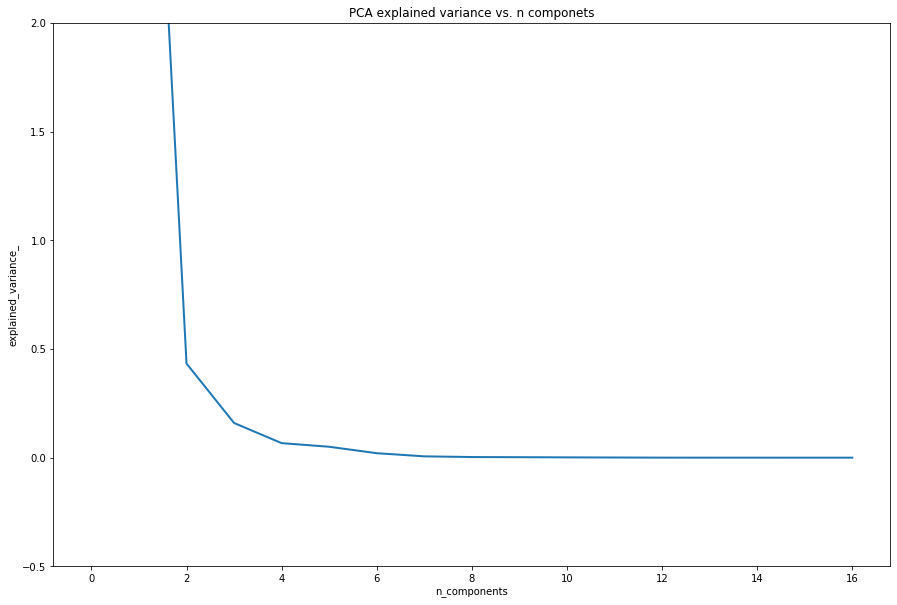

In [65]:
#normalize the X values
X_normalize = StandardScaler().fit_transform(X)

#apply PCA to visulaize the data in cluster
from sklearn.decomposition import PCA
#find explained variance and n_components

pca = PCA()
pca.fit(X_normalize)
plt.figure(figsize=(15, 10))
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')
plt.ylim(-0.5, 2)
plt.title('PCA explained variance vs. n componets')

(2205, 17)
(2205, 2)


Text(0.5, 1.0, 'Clustering of data when PCA dimension =2')

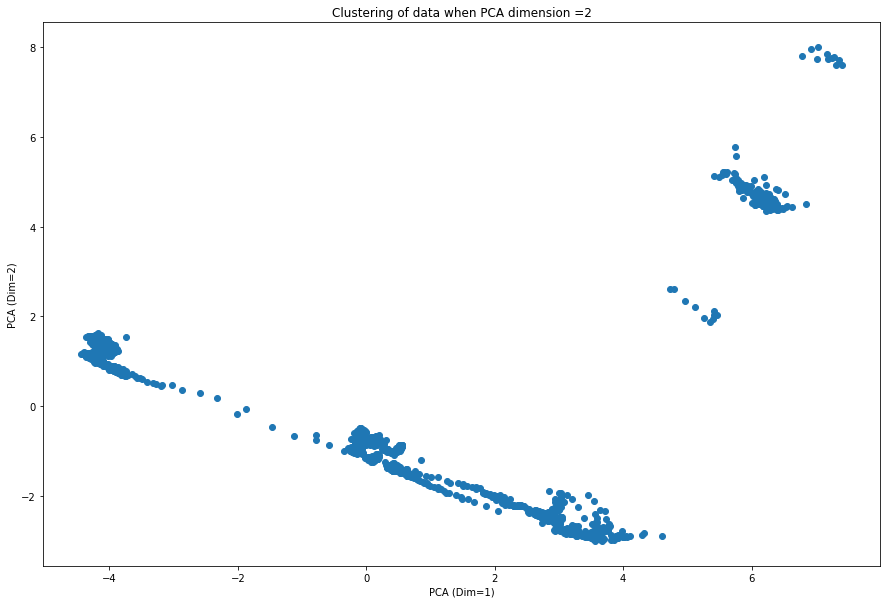

In [66]:
#observe distribution when n_componets =2
pca_2 = PCA(2)
projected = pca_2.fit_transform(X_normalize)
print(X.shape)
print(projected.shape)
plt.figure(figsize=(15, 10))
plt.scatter(projected[:, 0], projected[:,1])
plt.xlabel('PCA (Dim=1)')
plt.ylabel('PCA (Dim=2)')
plt.title('Clustering of data when PCA dimension =2')